In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import DateType, IntegerType
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("SmartHome").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


You are working with 1 core(s)


In [2]:
sensor = spark.read.parquet('gs://smarthome-326501/sensor_full.parquet')
sensor.limit(10).toPandas()

,sensor_id,value_id,timestamp,value,node_id,type,name
0,5891,60963123,2020-03-24 15:15:47.085843,0.0,541147,INT,livingroom/ambience/motion
1,5894,60963124,2020-03-24 15:15:47.159666,0.0,541150,INT,corridor/ambience/motion
2,5895,60963125,2020-03-24 15:15:47.167174,0.0,541151,INT,bathroom/ambience/motion
3,5889,60963126,2020-03-24 15:15:47.183545,325.0,541145,INT,livingroom/couch/pressure
4,5887,60963127,2020-03-24 15:15:47.242122,89.0,541143,INT,kitchen/stove/light
5,6253,60963130,2020-03-24 15:15:47.300435,0.0,541509,INT,kitchen/fridge/contact
6,6686,60963131,2020-03-24 15:15:47.391450,0.0,541885,INT,bedroom/ambience_under_the_bed/motion
7,6127,60963134,2020-03-24 15:15:47.642456,1024.0,541383,INT,livingroom/tv/light
8,5893,60963136,2020-03-24 15:15:47.675467,0.0,541149,INT,kitchen/ambience/motion
9,6220,60963137,2020-03-24 15:15:47.865781,0.0,541444,INT,balcon/door/contact


In [3]:
sensor = sensor.withColumn("timestamp", func.to_timestamp(sensor.timestamp))

In [4]:
active_threshold = {
    'balcon/door/contact' : 0, # max:1, min:0
    
    'bathroom/ambience/humidity' : 50, # max:98.56, min:15.2
    'bathroom/ambience/light' : 100, # max:1024, min:0
    'bathroom/ambience/motion' : 0, # max:1, min:0
    'bathroom/ambience/temperature' : 26, # max:29.23, min:21.13
    'bathroom/washingmachine/current' : 9, # max:141616.557, min:-141616.565
    
    'bedroom/ambience/motion' : 0, # max:1, min:0
    'bedroom/ambience_under_the_bed/motion' : 0, # max:1, min:0
    'bedroom/bed/pressure' : 600, # max:687, min:480
    'bedroom/weightscale/pressure' : 60, # max:293, min:0
    
    'corridor/ambience/motion' : 0, # max:1, min:0
    'corridor/ilifeRobot/current' : 9, # max:137744.237, min:0 
    
    'entrance/door/contact' : 0, # max:1, min:0
    
    'kitchen/ambience/motion' : 0, # max:1, min:0
    'kitchen/coffeemaker/current' : 1, # max:123914.494, min:0
    'kitchen/dishwasher/current' : 10, # max:137744.237, min:0 
    'kitchen/fridge/contact' : 0 , # max:1, min:0
    'kitchen/kettle/current' : 9, # max:97361.388, min:0
    'kitchen/microwave/current' : 9, # max:1343.936, min:0 
    'kitchen/sandwichmaker/current' : 9, # max:137744.237, min:0 
    'kitchen/stove/light' : 100, # max:1024, min:0,    
       
    'livingroom/ambience/motion' : 0, # max:1, min:0
    'livingroom/couch/pressure' : 300, # max:449.0, min:0
    'livingroom/tv/light' : 100 # max:1024, min:3,
}

In [5]:
class Smarthome:
    instances = []
    def __init__(self, name):
        self.name = name
        
    def creare_dataframe(self):
        self.dataframe = sensor.filter(sensor.name == self.name).select(['timestamp', 'value'])
        self.dataframe = self.dataframe.withColumn("timestamp", func.to_timestamp(self.dataframe .timestamp))
        
    def head(self, nrows=5):
        return self.dataframe.limit(nrows).toPandas()
    
    def binarizer(self, threshold=0):
        self.dataframe = self.dataframe.withColumn("value", self.dataframe["value"].cast(IntegerType()))
        self.dataframe = self.dataframe.withColumn("value", func.when(self.dataframe.value <= threshold,0).otherwise(1))
        self.dataframe = self.dataframe.select('timestamp','value').sort(func.asc('timestamp'))
        
    def start_end_timestamp(self):
        self.start = []
        self.end = []
        flag_one = 0
        flag_two = 0
        for row in self.dataframe.rdd.collect():
            flag_two = row.value
            if flag_one == 0 and flag_two == 1:
                self.start.append(row.timestamp)
            elif flag_one == 1 and flag_two == 0:
                self.end.append(row.timestamp)
    
            flag_one = flag_two
    
    def extract_hour_minute(self):
        self.hour = [self.start[i].hour for i in range(len(self.start))]
        self.minute = [self.end[i].minute for i in range(len(self.end))]
        
    def display_heatmap(self, annot=True):
        heatmap_df = pd.DataFrame(list(zip(self.hour, self.minute)), \
                                            columns =['hour', 'minute'])
        heatmap_df = heatmap_df.groupby(heatmap_df.columns.tolist()).\
                                        size().reset_index().rename(columns={0:'count'})
        heatmap_df = heatmap_df.pivot("minute", "hour", "count")
        f, ax = plt.subplots(figsize=(20, 12))
        ax = sns.heatmap(heatmap_df,annot=annot, cmap="YlGnBu")
    


In [6]:
def process_sensor_data(sensor_object, sensor_name):
    sensor_object.creare_dataframe()
    sensor_object.binarizer(active_threshold[sensor_name])
    sensor_object.start_end_timestamp()
    sensor_object.extract_hour_minute()

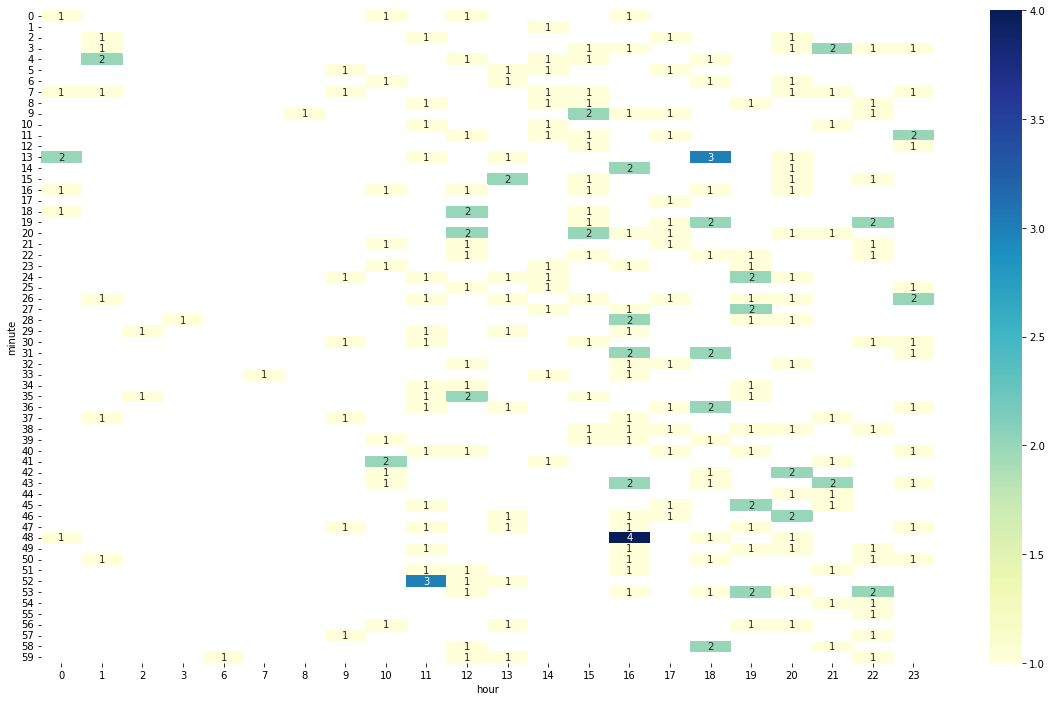

In [7]:
sensor_name = 'balcon/door/contact'
balcon_door_contact = Smarthome(sensor_name)
process_sensor_data(balcon_door_contact, sensor_name)
balcon_door_contact.display_heatmap()

In [8]:
sensor_name = 'bathroom/ambience/humidity'
bathroom_ambience_humidity = Smarthome(sensor_name)
bathroom_ambience_humidity.creare_dataframe()


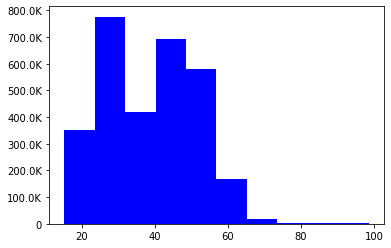

In [9]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, bathroom_ambience_humidity.dataframe.select('value'), color=['blue'])
plt.show()

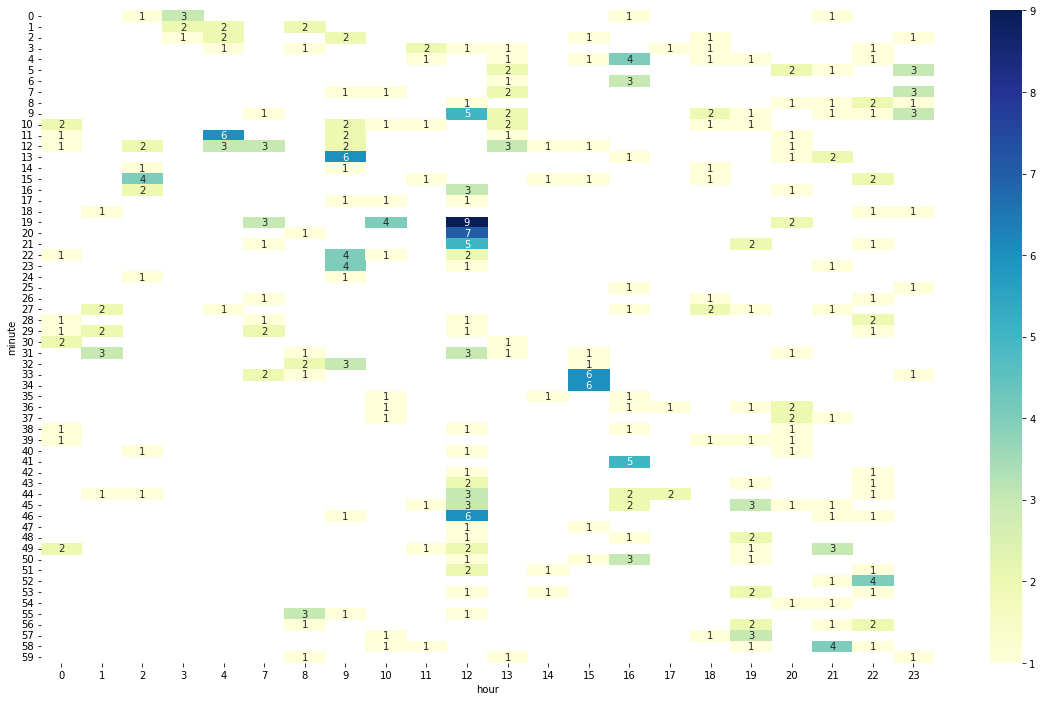

In [10]:
process_sensor_data(bathroom_ambience_humidity, sensor_name)
bathroom_ambience_humidity.display_heatmap()

In [11]:
sensor_name = 'bathroom/ambience/light'
bathroom_ambience_light = Smarthome(sensor_name)
bathroom_ambience_light.creare_dataframe()

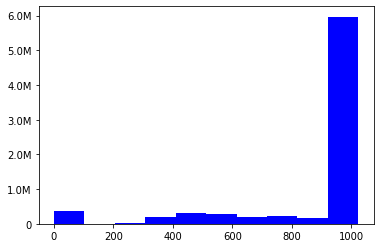

In [12]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, bathroom_ambience_light.dataframe.select('value'), color=['blue'])
plt.show()

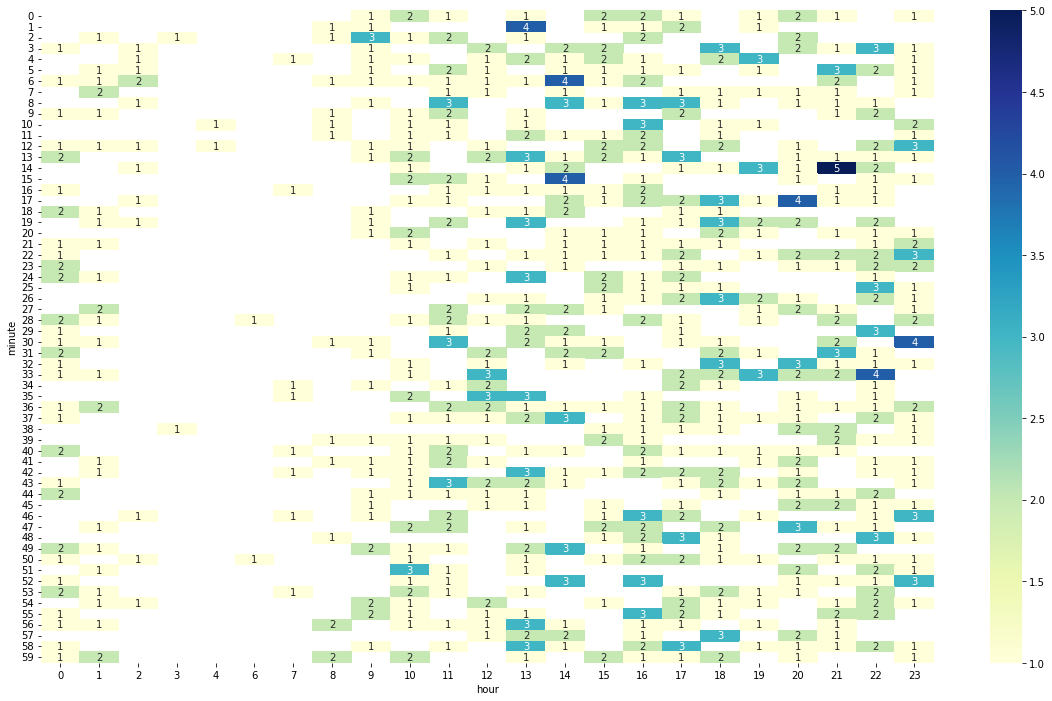

In [13]:
process_sensor_data(bathroom_ambience_light, sensor_name)
bathroom_ambience_light.display_heatmap()

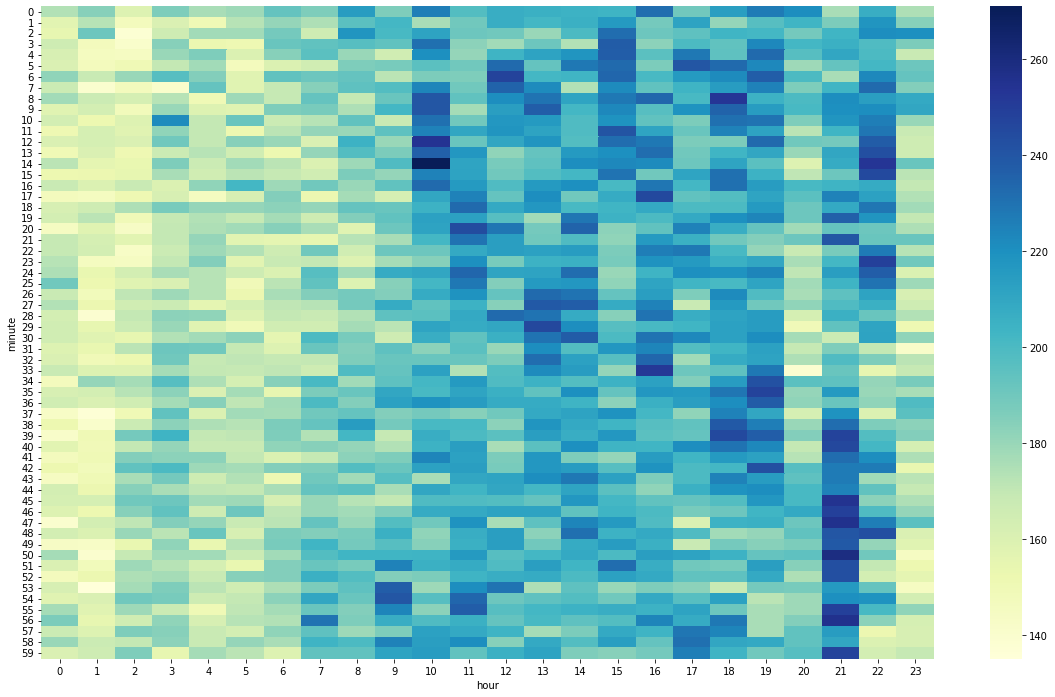

In [14]:
sensor_name = 'bathroom/ambience/motion'
bathroom_ambience_motion = Smarthome(sensor_name)
process_sensor_data(bathroom_ambience_motion, sensor_name)
bathroom_ambience_motion.display_heatmap(annot=False)

In [15]:
sensor_name = 'bathroom/ambience/temperature'
bathroom_ambience_temperature = Smarthome(sensor_name)
bathroom_ambience_temperature.creare_dataframe()

In [16]:
bathroom_ambience_temperature.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

29.32

In [ ]:
process_sensor_data(bathroom_ambience_temperature, sensor_name)
bathroom_ambience_temperature.display_heatmap()

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, bathroom_ambience_temperature.dataframe.select('value'), color=['blue'])
plt.show()

In [ ]:
sensor_name = 'bathroom/washingmachine/current'
bathroom_washingmachine_current = Smarthome(sensor_name)
bathroom_washingmachine_current.creare_dataframe()

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, bathroom_washingmachine_current.dataframe.select('value'), color=['blue'])
plt.show()

In [ ]:
bathroom_washingmachine_current.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
process_sensor_data(bathroom_washingmachine_current, sensor_name)
bathroom_washingmachine_current.display_heatmap()

In [ ]:
sensor_name = 'bedroom/ambience/motion'
bedroom_ambience_motion = Smarthome(sensor_name)
process_sensor_data(bedroom_ambience_motion, sensor_name)
bedroom_ambience_motion.display_heatmap(annot=False)

In [ ]:
sensor_name = 'bedroom/ambience_under_the_bed/motion'
under_the_bed_motion = Smarthome(sensor_name)
under_the_bed_motion.creare_dataframe()

In [ ]:
under_the_bed_motion.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

In [ ]:
process_sensor_data(under_the_bed_motion, sensor_name)
under_the_bed_motion.display_heatmap(annot=False)

In [ ]:
sensor_name = 'bedroom/bed/pressure'
bedroom_bed_pressure = Smarthome(sensor_name)
bedroom_bed_pressure.creare_dataframe()

In [ ]:
bedroom_bed_pressure.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, bedroom_bed_pressure.dataframe.select('value'), color=['blue'])
plt.show()

In [ ]:
process_sensor_data(bedroom_bed_pressure, sensor_name)
bedroom_bed_pressure.display_heatmap()

In [ ]:
sensor_name = 'bedroom/weightscale/pressure'
bedroom_weightscale_pressure= Smarthome(sensor_name)
bedroom_weightscale_pressure.creare_dataframe()

In [ ]:
bedroom_weightscale_pressure.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

In [ ]:
process_sensor_data(bedroom_weightscale_pressure, sensor_name)
bedroom_weightscale_pressure.display_heatmap()

In [ ]:
sensor_name = 'corridor/ambience/motion'
corridor_ambience_motion= Smarthome(sensor_name)


In [ ]:
corridor_ambience_motion.creare_dataframe()


In [ ]:
corridor_ambience_motion.binarizer(active_threshold[sensor_name])


In [ ]:
corridor_ambience_motion.start_end_timestamp()


In [ ]:
corridor_ambience_motion.extract_hour_minute()


In [ ]:
corridor_ambience_motion.display_heatmap(annot=False)

In [ ]:
sensor_name = 'corridor/ilifeRobot/current'
corridor_ilifeRobot_current= Smarthome(sensor_name)
corridor_ilifeRobot_current.creare_dataframe()

In [ ]:
corridor_ilifeRobot_current.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, corridor_ilifeRobot_current.dataframe.select('value'), color=['blue'])
plt.show()

In [ ]:
process_sensor_data(corridor_ilifeRobot_current, sensor_name)
corridor_ilifeRobot_current.display_heatmap()

In [ ]:
sensor_name = 'entrance/door/contact'
entrance_door_contact= Smarthome(sensor_name)
entrance_door_contact.creare_dataframe()

In [ ]:
entrance_door_contact.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

In [ ]:
process_sensor_data(entrance_door_contact, sensor_name)
entrance_door_contact.display_heatmap()

In [ ]:
sensor_name = 'kitchen/ambience/motion'
kitchen_ambience_motion= Smarthome(sensor_name)
kitchen_ambience_motion.creare_dataframe()

In [ ]:
kitchen_ambience_motion.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
process_sensor_data(kitchen_ambience_motion, sensor_name)

In [ ]:
kitchen_ambience_motion.display_heatmap(annot=False)

In [ ]:
sensor_name = 'kitchen/coffeemaker/current'
kitchen_coffeemaker_current= Smarthome(sensor_name)
kitchen_coffeemaker_current.creare_dataframe()

In [ ]:
kitchen_coffeemaker_current.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

In [ ]:
process_sensor_data(kitchen_coffeemaker_current, sensor_name)
kitchen_coffeemaker_current.display_heatmap()

In [ ]:
sensor_name = 'kitchen/dishwasher/current'
kitchen_dishwasher_current= Smarthome(sensor_name)
kitchen_dishwasher_current.creare_dataframe()

In [ ]:
kitchen_dishwasher_current.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, kitchen_dishwasher_current.dataframe.select('value'), color=['blue'])
plt.show()

In [ ]:
process_sensor_data(kitchen_dishwasher_current, sensor_name)
kitchen_dishwasher_current.display_heatmap()

In [ ]:
sensor_name = 'kitchen/fridge/contact'
kitchen_fridge_contact= Smarthome(sensor_name)
kitchen_fridge_contact.creare_dataframe()

In [ ]:
kitchen_fridge_contact.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
process_sensor_data(kitchen_fridge_contact, sensor_name)
kitchen_fridge_contact.display_heatmap()

In [ ]:
sensor_name = 'kitchen/kettle/current'
kitchen_kettle_current= Smarthome(sensor_name)
kitchen_kettle_current.creare_dataframe()

In [ ]:
kitchen_kettle_current.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

In [ ]:
process_sensor_data(kitchen_kettle_current, sensor_name)
kitchen_kettle_current.display_heatmap()

In [ ]:
sensor_name = 'kitchen/microwave/current'
kitchen_microwave_current= Smarthome(sensor_name)
kitchen_microwave_current.creare_dataframe()

In [ ]:
kitchen_microwave_current.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, kitchen_microwave_current.dataframe.select('value'), color=['blue'])
plt.show()

In [ ]:
process_sensor_data(kitchen_microwave_current, sensor_name)
kitchen_microwave_current.display_heatmap()

In [ ]:
sensor_name = 'kitchen/sandwichmaker/current'
kitchen_sandwichmaker_current= Smarthome(sensor_name)
kitchen_sandwichmaker_current.creare_dataframe()

In [ ]:
kitchen_sandwichmaker_current.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

In [ ]:
process_sensor_data(kitchen_sandwichmaker_current, sensor_name)
kitchen_sandwichmaker_current.display_heatmap()

In [ ]:
sensor_name = 'kitchen/stove/light'
kitchen_stove_light= Smarthome(sensor_name)
kitchen_stove_light.creare_dataframe()

In [ ]:
kitchen_stove_light.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
process_sensor_data(kitchen_stove_light, sensor_name)
kitchen_stove_light.display_heatmap(annot=False)

In [ ]:
sensor_name = 'livingroom/ambience/motion'
livingroom_ambience_motion= Smarthome(sensor_name)
livingroom_ambience_motion.creare_dataframe()

In [ ]:
livingroom_ambience_motion.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

In [ ]:
process_sensor_data(livingroom_ambience_motion, sensor_name)
kitchen_stove_light.display_heatmap(annot=False)

In [ ]:
sensor_name = 'livingroom/couch/pressure'
livingroom_couch_pressure= Smarthome(sensor_name)
livingroom_couch_pressure.creare_dataframe()

In [ ]:
livingroom_couch_pressure.dataframe.select('value').agg({'value': 'min'}).collect()[0][0]

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, livingroom_couch_pressure.dataframe.select('value'), color=['blue'])
plt.show()

In [ ]:
process_sensor_data(livingroom_couch_pressure, sensor_name)

In [ ]:
livingroom_couch_pressure.display_heatmap()

In [ ]:
sensor_name = 'livingroom/tv/light'
livingroom_tv_light= Smarthome(sensor_name)
livingroom_tv_light.creare_dataframe()

In [ ]:
livingroom_tv_light.dataframe.select('value').agg({'value': 'max'}).collect()[0][0]

In [ ]:
process_sensor_data(livingroom_tv_light, sensor_name)

In [ ]:
livingroom_tv_light.display_heatmap()

In [ ]:
df1 = pd.DataFrame(balcon_door_contact.start)
df1['sensor_name'] = 'balcon/door/contact'
df1.columns = ['timestamp', 'sensor_name']
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

df2 = pd.DataFrame(bathroom_ambience_humidity.start)
df2['sensor_name'] = 'bathroom/ambience/humidity'
df2.columns = ['timestamp', 'sensor_name']
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

df3 = pd.DataFrame(bathroom_ambience_light.start)
df3['sensor_name'] = 'bathroom/ambience/light'
df3.columns = ['timestamp', 'sensor_name']
df3['timestamp'] = pd.to_datetime(df3['timestamp'])

df4 = pd.DataFrame(bathroom_ambience_motion.start)
df4['sensor_name'] = 'bathroom/ambience/motion'
df4.columns = ['timestamp', 'sensor_name']
df4['timestamp'] = pd.to_datetime(df4['timestamp'])

df5 = pd.DataFrame(bathroom_ambience_temperature.start)
df5['sensor_name'] = 'bathroom/ambience/temperature'
df5.columns = ['timestamp', 'sensor_name']
df5['timestamp'] = pd.to_datetime(df5['timestamp'])

df6 = pd.DataFrame(bathroom_washingmachine_current.start)
df6['sensor_name'] = 'bathroom/washingmachine/current'
df6.columns = ['timestamp', 'sensor_name']
df6['timestamp'] = pd.to_datetime(df6['timestamp'])

df7 = pd.DataFrame(bedroom_ambience_motion.start)
df7['sensor_name'] = 'bedroom/ambience/motion'
df7.columns = ['timestamp', 'sensor_name']
df7['timestamp'] = pd.to_datetime(df7['timestamp'])

df8 = pd.DataFrame(under_the_bed_motion.start)
df8['sensor_name'] = 'bedroom/ambience_under_the_bed/motion'
df8.columns = ['timestamp', 'sensor_name']
df8['timestamp'] = pd.to_datetime(df8['timestamp'])

df9 = pd.DataFrame(bedroom_bed_pressure.start)
df9['sensor_name'] = 'bedroom/bed/pressure'
df9.columns = ['timestamp', 'sensor_name']
df9['timestamp'] = pd.to_datetime(df9['timestamp'])

df10 = pd.DataFrame(bedroom_weightscale_pressure.start)
df10['sensor_name'] = 'bedroom/weightscale/pressure'
df10.columns = ['timestamp', 'sensor_name']
df10['timestamp'] = pd.to_datetime(df10['timestamp'])

df11 = pd.DataFrame(corridor_ambience_motion.start)
df11['sensor_name'] = 'corridor/ambience/motion'
df11.columns = ['timestamp', 'sensor_name']
df11['timestamp'] = pd.to_datetime(df11['timestamp'])

df12 = pd.DataFrame(corridor_ilifeRobot_current.start)
df12['sensor_name'] = 'corridor/ilifeRobot/current'
df12.columns = ['timestamp', 'sensor_name']
df12['timestamp'] = pd.to_datetime(df12['timestamp'])

df13 = pd.DataFrame(entrance_door_contact.start)
df13['sensor_name'] = 'entrance/door/contact'
df13.columns = ['timestamp', 'sensor_name']
df13['timestamp'] = pd.to_datetime(df13['timestamp'])

df14 = pd.DataFrame(kitchen_ambience_motion.start)
df14['sensor_name'] = 'kitchen/ambience/motion'
df14.columns = ['timestamp', 'sensor_name']
df14['timestamp'] = pd.to_datetime(df14['timestamp'])

df15 = pd.DataFrame(kitchen_coffeemaker_current.start)
df15['sensor_name'] = 'kitchen/coffeemaker/current'
df15.columns = ['timestamp', 'sensor_name']
df15['timestamp'] = pd.to_datetime(df15['timestamp'])

df16 = pd.DataFrame(kitchen_dishwasher_current.start)
df16['sensor_name'] = 'kitchen/dishwasher/current'
df16.columns = ['timestamp', 'sensor_name']
df16['timestamp'] = pd.to_datetime(df16['timestamp'])

df17 = pd.DataFrame(kitchen_fridge_contact.start)
df17['sensor_name'] = 'kitchen/fridge/contact'
df17.columns = ['timestamp', 'sensor_name']
df17['timestamp'] = pd.to_datetime(df17['timestamp'])

df18 = pd.DataFrame(kitchen_kettle_current.start)
df18['sensor_name'] = 'kitchen/kettle/current'
df18.columns = ['timestamp', 'sensor_name']
df18['timestamp'] = pd.to_datetime(df18['timestamp'])

df19 = pd.DataFrame(kitchen_microwave_current.start)
df19['sensor_name'] = 'kitchen/microwave/current'
df19.columns = ['timestamp', 'sensor_name']
df19['timestamp'] = pd.to_datetime(df19['timestamp'])

df20 = pd.DataFrame(kitchen_sandwichmaker_current.start)
df20['sensor_name'] = 'kitchen/sandwichmaker/current'
df20.columns = ['timestamp', 'sensor_name']
df20['timestamp'] = pd.to_datetime(df1['timestamp'])

df21 = pd.DataFrame(kitchen_stove_light.start)
df21['sensor_name'] = 'kitchen/stove/light'
df21.columns = ['timestamp', 'sensor_name']
df21['timestamp'] = pd.to_datetime(df21['timestamp'])

df22 = pd.DataFrame(livingroom_ambience_motion.start)
df22['sensor_name'] = 'livingroom/ambience/motion'
df22.columns = ['timestamp', 'sensor_name']
df22['timestamp'] = pd.to_datetime(df22['timestamp'])

df23 = pd.DataFrame(livingroom_couch_pressure.start)
df23['sensor_name'] = 'livingroom/couch/pressure'
df23.columns = ['timestamp', 'sensor_name']
df23['timestamp'] = pd.to_datetime(df23['timestamp'])

df24 = pd.DataFrame(livingroom_tv_light.start)
df24['sensor_name'] = 'livingroom/tv/light'
df24.columns = ['timestamp', 'sensor_name']
df24['timestamp'] = pd.to_datetime(df24['timestamp'])

frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23, df24]
df = pd.concat(frames)
df = df.sort_values(by='timestamp')
df

In [ ]:
import itertools
df = df.groupby(df['timestamp'].dt.date)['sensor_name'].apply(lambda x: ','.join(x))
df = df.reset_index()
df['sequence'] = df['sensor_name'].apply(lambda x: x.split(","))
df['sequence'] = df['sequence'].apply(lambda myList: [ [x,y] for x,y in zip(myList, myList[1:])])
df['sequence'] = df['sequence'].apply(lambda myList: list(myList for myList,_ in itertools.groupby(myList)))
df['sequence'] = df['sequence'].apply(lambda myList: [x for x in myList if x[0] != x[1]])

In [ ]:
df.head()

In [ ]:
spark_df = spark.createDataFrame(df)

In [ ]:
df_array = spark_df.select('sequence')

In [ ]:
from pyspark.ml.fpm import PrefixSpan

prefixSpan = PrefixSpan(minSupport=0.94, maxPatternLength=3)

# Find frequent sequential patterns.
sequence = prefixSpan.findFrequentSequentialPatterns(df_array)


In [ ]:
sequence.where(func.size(func.col("sequence")) > 1).take(200)

In [ ]:
from pyspark.sql.functions import expr, round

#get the size of each array within the arrays
filtered = sequence.withColumn('size', expr('transform(sequence, x -> size(x))'))
# sequence.withColumn("length",size(col("sequence")))

# Let's also add a column that tells us the percentage of the sequences
row_cnt = df_array.count()
filtered = filtered.withColumn('percentage',round((func.col("freq")/row_cnt)*100,2))
# Then filter out only the ones with more than 2 elements
filtered = filtered.where(func.array_contains(filtered.size, 2))
filtered.show()

In [ ]:
filtered.take(200)

In [ ]:
entrance_door_contact.start[0], len(entrance_door_contact.end)